In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data=pd.read_csv(r"D:\Data Set\housing.csv")
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
data.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [5]:
data.shape

(20640, 10)

In [6]:
data.dropna(axis=1,inplace=True)
data.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [7]:
new=data.select_dtypes(include='object').columns.tolist()
new

['ocean_proximity']

In [53]:
for i in new:
    print(i,data[i].unique())

ocean_proximity [0 1 2]


In [8]:
from sklearn.preprocessing import LabelEncoder
label=LabelEncoder()
for i in new:
    data[i]=label.fit_transform(data[i])
    
data.head()

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,322.0,126.0,8.3252,452600.0,3
1,-122.22,37.86,21.0,7099.0,2401.0,1138.0,8.3014,358500.0,3
2,-122.24,37.85,52.0,1467.0,496.0,177.0,7.2574,352100.0,3
3,-122.25,37.85,52.0,1274.0,558.0,219.0,5.6431,341300.0,3
4,-122.25,37.85,52.0,1627.0,565.0,259.0,3.8462,342200.0,3


In [9]:
data.shape

(20640, 9)

In [10]:
q1=data.quantile(0.25)
q3=data.quantile(0.75)
iqr=q3-q1

data=data[~((data<(q1-1.5*iqr))|((data>(q3+1.5*iqr)))).any(axis=1)]

In [11]:
data.shape

(13519, 9)

In [12]:
X=data.drop(columns='median_house_value')
y=data['median_house_value']

In [13]:
from sklearn.model_selection import train_test_split
Xtrain,Xtest,ytrain,ytest=train_test_split(X,y,test_size=0.3,random_state=42)

<Axes: >

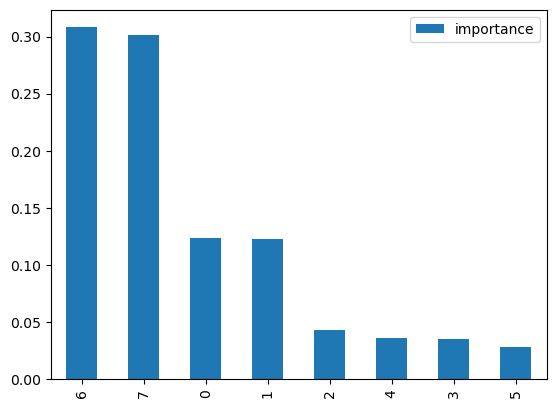

In [14]:
from sklearn.ensemble import RandomForestRegressor
model=RandomForestRegressor(n_estimators=25)
model.fit(Xtrain,ytrain)

importance=model.feature_importances_

final_features=pd.DataFrame({
    'features':pd.DataFrame(X).columns,
    'importance':importance
})
final_features=final_features.sort_values(by='importance',ascending=False)

final_features.plot.bar()

In [15]:
X.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'population', 'households', 'median_income', 'ocean_proximity'],
      dtype='object')

In [16]:
from sklearn.linear_model import Lasso
l=Lasso()
l.fit(Xtrain,ytrain)
l.coef_

array([-1.72270471e+04, -1.77940056e+04,  5.35049567e+02, -2.77737944e+00,
       -6.10154391e+01,  2.04780203e+02,  3.33182008e+04, -4.59730410e+04])

In [17]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

estimator=LinearRegression()
selector=RFE(estimator,n_features_to_select=5)
selector.fit(X,y)
new_feature=selector.transform(X)
np.array(X.columns)[selector.support_]

array(['longitude', 'latitude', 'housing_median_age', 'median_income',
       'ocean_proximity'], dtype=object)

In [18]:
from sklearn.preprocessing import StandardScaler
scale=StandardScaler()
X_train_scale=scale.fit_transform(Xtrain)
X_test_scale=scale.fit_transform(Xtest)

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso,LinearRegression

In [27]:
model1=DecisionTreeRegressor()

param_grid={
    'max_depth':[3,5,7],
    'min_samples_leaf':[1,2,3,4],
    'min_samples_split':[2,3,4,5]
}

grid_searchcv=GridSearchCV(
     estimator=model1,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=5,
    verbose=2
)
grid_searchcv.fit(X_train_scale,ytrain)
print("best score",grid_searchcv.best_score_)
print('best param:',grid_searchcv.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
best score -2479596620.6985826
best param: {'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 5}


In [29]:
best1=grid_searchcv.best_estimator_
best1

DecisionTreeRegressor(max_depth=7, min_samples_leaf=4, min_samples_split=5)

In [31]:
ypred_dt=best1.predict(X_test_scale)

In [32]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

In [33]:
r2_dt=r2_score(ytest,ypred_dt)
r2_dt

0.7091866218520086

In [36]:
model2=RandomForestRegressor()

param_grid={
    'max_depth':[3,5,7],
    'min_samples_leaf':[1,2,3,4],
    'min_samples_split':[2,3,4,5]
}

grid_searchcv=GridSearchCV(
    estimator=model2,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=5,
    verbose=2,
)

grid_searchcv.fit(X_train_scale,ytrain)

print('best_param:',grid_searchcv.best_params_)
print('best_score:',grid_searchcv.best_score_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
best_param: {'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 2}
best_score: -2105967986.2413146


In [37]:
best2=grid_searchcv.best_estimator_
best2

RandomForestRegressor(max_depth=7, min_samples_leaf=4)

In [41]:
ypred_r=best2.predict(X_test_scale)

In [42]:
r2_r=r2_score(ytest,ypred_r)
r2_r

0.74119523668338

In [44]:
model3=Lasso()

param_grid={
    'alpha':[0.1,1,10]
}

gridsearchcv=GridSearchCV(
    estimator=model3,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=3,
    verbose=0,)

gridsearchcv.fit(X_train_scale,ytrain)

print('Best_param:',gridsearchcv.best_params_)
print('Best_score:',gridsearchcv.best_score_)

Best_param: {'alpha': 0.1}
Best_score: -2982734280.069345


In [45]:
best3=gridsearchcv.best_estimator_
best3

Lasso(alpha=0.1)

In [46]:
ypred_l=best3.predict(X_test_scale)

In [48]:
r2_l=r2_score(ytest,ypred_l)
r2_l

0.6446032609836463